In [1]:
import GPy
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import tqdm
import scipy
import seaborn as sns
from math import nan, isnan
import time

import tensorflow as tf
import tf_agents
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()
np.random.seed(1)
random.seed(1)

import warnings
warnings.filterwarnings("ignore")

In [2]:
def flatten(liste):
    return [item for sublist in liste for item in sublist]

def preprocessing(X_s):
    X = []
    for liste in X_s:
        X += liste.copy()
    return np.array(X)

def copie_paths(paths):
    X = []
    for liste in paths:
        X.append(liste.copy())
    return X

def copy_X_D(X_D):
    X = []
    for liste in X_D:
        X.append(liste.copy())
    return np.array(X)

def concatenate(x, y):
    if len(x)==0:
        return y
    else:
        return np.concatenate((x, y))

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def distance(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
        
def sigma_matrix(gp_model, X_v):
    return gp_model.kern.K(X_v, X_v)
    
def sigma_prime_matrix(gp_model, X_v, X_s):
    kernel = gp_model.rbf
    variance_n = float(gp_model.Gaussian_noise.variance)
    a = kernel.K(X_v, X_v)
    b = kernel.K(X_v, X_s)
    c = kernel.K(X_s, X_s)
    d = variance_n*np.eye(len(X_s))
    e = kernel.K(X_s, X_v)
    f = np.linalg.inv(c + d)
    g = np.dot(b, f)
    h = np.dot(g, e)
    return a - h

def f_D(gp_model, X_v, X_s):
    sigma = sigma_matrix(gp_model, X_v)
    sigma_prime = sigma_prime_matrix(gp_model, X_v, X_s)
    return 0.5 * (np.log(np.linalg.det(sigma)) - np.log(np.linalg.det(sigma_prime)))

def reward_function(gp_model, X_v, X_s_old, X_s_new):
    if len(X_s_old)==0:
        sigma_prime_old = sigma_matrix(gp_model, X_v)
    else:
        sigma_prime_old = sigma_prime_matrix(gp_model, X_v, X_s_old)
    if len(X_s_new)==0:
        sigma_prime_new = sigma_matrix(gp_model, X_v)
    else:
        sigma_prime_new = sigma_prime_matrix(gp_model, X_v, X_s_new)
    return 0.5 * (np.log(np.linalg.det(sigma_prime_old)) - np.log(np.linalg.det(sigma_prime_new)))

def credit_assignment(env, reward, dones):
    if env.nb_agents==1:
        return np.array([reward])
    rewards = np.zeros(env.nb_agents)
    if reward==0:
        return rewards
    X_s = preprocessing(env.X_s)
    H = np.log(np.linalg.det(sigma_prime_matrix(env.gp_model, env.X_v, X_s)))
    for i in range(env.nb_agents):
        if not dones[i]:
            X_s_i = env.X_s.copy()
            del X_s_i[i]
            X_s_i = preprocessing(X_s_i)
            if len(X_s_i)==0:
                rewards[i] = 0.5 * (np.log(np.linalg.det(sigma_matrix(env.gp_model, env.X_v))) - H)
            else:
                rewards[i] = 0.5 * (np.log(np.linalg.det(sigma_prime_matrix(env.gp_model, env.X_v, X_s_i))) - H)
    somme = np.sum(rewards)
    if somme==0:
        return rewards
    return rewards*(reward/(np.sum(rewards)))

def construct_graph(graph_dim, graph_unity):
    x = graph_dim[0]
    y = graph_dim[1]
    i, j = 0.0, 0.0
    graph = nx.Graph()
    for k in range(x*y):
        graph.add_node(k, coord=[i, j])
        i += graph_unity
        if i==x*graph_unity:
            i = 0.0
            j += graph_unity
    for k in range(x*y):
        if (k+1)%x!=0:
            graph.add_edge(k, k+1)
        if k<x*y-x:
            graph.add_edge(k, k+x)
    return graph
            
def show_graph(graph):
    nx.draw(graph, with_labels=True, font_weight='bold')

def remove_nodes_from_graph(graph, liste):
    graph.remove_nodes_from(liste)
    return graph

def pollutant_concentration(x, y, z, Q, u, h_s, g, V, T_a, T_s, a_y, b_y, a_z, b_z):
    if x==0:
        x = 0.7
    sigma_y = sigma_function(x, a_y, b_y)
    sigma_z = sigma_function(x, a_z, b_z)
    H = h_s + delta_h(x, u, g, V, T_a, T_s)
    return (Q/(2*np.pi*u*sigma_y*sigma_z))*np.exp(-y**2/(2*sigma_y))*(np.exp(-(z-H)**2/(2*sigma_y))+np.exp(-(z+H)**2/(2*sigma_y)))

def sigma_function(x, a, b):
    return a * (abs(x) ** b)

def delta_h(x, u, g, V, T_a, T_s):
    F = (g/np.pi) * V * ((T_s - T_a)/T_s)
    return (1.6 * (F**(1/3)) * (x**(2/3))) / u

def incertitude_initiale(sigma, graph):
    return 0.5 * np.log(np.linalg.det(sigma)) + (graph.number_of_nodes()/2) * (1 + np.log(2*np.pi))

def coord_to_id(coord, graph_dim):
    return graph_dim[0] * int(coord[1]) + int(coord[0])

def plot_heat_map(means, graph_dim, ax=None):
    means = np.reshape(np.array(means), (graph_dim[0],graph_dim[1]))
    ax = sns.heatmap(means, linewidth = 0, cmap = 'coolwarm', ax=ax)
    ax.invert_yaxis()
    plt.show()
    
def plot_results(steps, avg_rewards, err, train_py_env, grd_truth_variances, grd_truth_lengthscales, perturbations_steps):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].plot(steps, avg_rewards)
    axs[1].plot(steps, err)
    axs[2].plot(range(1,len(train_py_env.liste_variances)+1), train_py_env.liste_variances)
    axs[3].plot(range(1,len(train_py_env.liste_lengthscales)+1), train_py_env.liste_lengthscales)
    for var in grd_truth_variances:
        axs[2].axhline(y=10, color='red', linestyle='--')
    for l in grd_truth_lengthscales:
        axs[3].axhline(y=l, color='red', linestyle='--')
    for s in perturbations_steps:
        axs[1].axvline(x=s, color='green', linestyle='--')
        axs[2].axvline(x=s/100, color='green', linestyle='--')
        axs[3].axvline(x=s/100, color='green', linestyle='--')
        
def compute_means(graph_dim, height, Q, u, h_s, g, V, T_a, T_s, a_y, b_y, a_z, b_z, display=False):
    means = []
    i = 0
    j = -1 * int(graph_dim[1]/2)
    i_m = 0
    j_m = 0
    matrice = [[-1 for _ in range(graph_dim[0])] for _ in range(graph_dim[1])]
    for _ in range(graph_dim[1]):
        for _ in range(graph_dim[0]):
            concentration = pollutant_concentration(i, j, height, Q, u, h_s, g, V, T_a, T_s, a_y, b_y, a_z, b_z)
            means.append(concentration + 10)
            matrice[i_m][j_m] = concentration
            i += 1
            j_m += 1
        j += 1
        i = 0
        j_m = 0
        i_m += 1
    if display:
        ax = sns.heatmap(matrice, linewidth = 0, cmap = 'coolwarm')
        ax.invert_yaxis()
    return means

In [3]:
def collect_pilot_data(nb_agents, exploration_steps, graph, graph_dim, means, variance, lengthscale, memory_window, gamma):
    X_D = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
    simulation_kernel = GPy.kern.RBF(input_dim = 2, variance=variance, lengthscale=lengthscale)
    cov = simulation_kernel.K(X_D)
    X, Y = [], []
    for _ in range(exploration_steps):
        Y_D = np.random.multivariate_normal(np.array(means), cov, 1)[0]
        Y_D = np.reshape(Y_D, (len(Y_D),1))
        Y_D[Y_D<0] = 0.1
        sparse_nodes = random.sample(range(0, graph.number_of_nodes()), nb_agents)
        
        for i in sparse_nodes:
            l = variances[i]
            l[0], l[1], l[2] = weighted_variance(l[0], l[1], l[2], Y_D[i][0], memory_window, gamma)
        
        sorted_nodes = sorted(sparse_nodes)
        
        for j in range(len(sorted_nodes)):
            if j==0 or sorted_nodes[j]!=sorted_nodes[j-1]:
                for i in range(len(sorted_nodes)):
                    if sorted_nodes[i]!=sorted_nodes[j] and (sorted_nodes[i]!=sorted_nodes[i-1] or i==0):
                        if distance(X_D[sorted_nodes[j]], X_D[sorted_nodes[i]])<=2.83:
                            l = liste_covariances[sorted_nodes[j]][sorted_nodes[i]]
                            l[0], l[1], l[2], l[3] = weighted_covariance(l[0], l[1], l[2], l[3], Y_D[sorted_nodes[j]], Y_D[sorted_nodes[i]], memory_window, gamma)
        """
        if sorted_nodes[0]==0:
            for i in range(1,len(sorted_nodes)):
                if sorted_nodes[i]!=sorted_nodes[i-1]:
                    l = covariances[sorted_nodes[i]]
                    l[0], l[1], l[2], l[3] = weighted_covariance(l[0], l[1], l[2], l[3], Y_D[0], Y_D[sorted_nodes[i]], memory_window, gamma)
        """
        X.append(X_D[sparse_nodes])
        Y.append(Y_D[sparse_nodes])
    return incertitude_initiale(cov, graph), np.array(X), np.array(Y)

def hyperparameters_estimator(gp_model, graph, graph_dim, memory_window, gamma):
    cumul_var = 0
    coeffs = 0
    for ele in variances:
        coeffs += ele[2]
        cumul_var += float(ele[0])*ele[2]
    variance = cumul_var/coeffs
    ###########################################
    X_v = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
    moyenne = np.reshape(gp_model.predict(X_v)[0], (graph.number_of_nodes(),))
    ###########################################
    lengthscale, cpt = 0, 0
    for j in range(len(liste_covariances)):
        covariances = liste_covariances[j]
    #j = 0
        for i in range(len(covariances)):
            if covariances[i][0]>1:
                covariance = covariances[i][1] - covariances[i][2] * covariances[i][3]
                if 0<covariance<variance:
                    cpt += covariances[i][0]
                    lengthscale += find_lengthscale(X_v[j], X_v[i], covariance, variance) * covariances[i][0]
    if cpt!=0:
        lengthscale /= cpt
    else:
        lengthscale = 0
    return moyenne, variance, lengthscale

def find_lengthscale(x1, x2, y, var):
    return distance(x1, x2) * np.sqrt(-0.5/np.log(y/var))

def weighted_covariance(n, moy_prod, moy_x, moy_y, x_new, y_new, memory_capacity, gamma):
    if n>memory_capacity:
        return n + 1, gamma * moy_prod + (1-gamma) * x_new * y_new, gamma * moy_x + (1-gamma) * x_new, gamma * moy_y + (1-gamma) * y_new
    return n + 1, (n * moy_prod + x_new * y_new)/(n + 1), (n * moy_x + x_new)/(n + 1), (n * moy_y + y_new)/(n + 1)

def weighted_variance(var, moy, n, x_new, memory_capacity, gamma):
    if n>memory_capacity:
        a = gamma*(var+(moy**2)) + (1-gamma)*(x_new**2)
        moy = gamma * moy + (1-gamma) * x_new
    else:
        a = (n*(var+(moy**2)) + (x_new**2))/(n+1)
        moy = (n*moy+x_new)/(n+1)
    return a-moy**2, moy, n+1

Variance:  8.376112385928357
Lengthscale:  [1.15751322]
Carte:  [ 10.75264642  11.32311613  13.85837336  12.52638523  11.51614467
  14.26300441  16.43195461  19.71007937  24.20090585  22.62500812
  22.57812952  27.42825908  26.69219251  25.30725892  26.74695744
  27.63871459  29.25577269  27.87252782  25.01938148  28.40663161
  12.22154859   9.31322866  12.72050845  22.14726489  33.56912308
  41.40376403  47.79509584  52.22866103  55.73184379  55.12396075
  52.05524861  54.38021197  55.89885196  54.07704346  51.12148767
  49.17514734  49.83604216  48.34496765  46.03558747  44.25345014
   9.16774964  15.7158314   56.53395853  90.96553637 109.75350196
 115.94510822 116.08069696 112.42534523 105.97966991 101.11189841
  96.12391102  91.66553846  86.84427813  83.1268019   80.76306415
  75.22874615  68.9956136   65.00195555  62.43930201  60.28350973
  15.02880092  35.8379208  112.37730138 159.94626947 170.02638082
 167.35304548 157.51962971 147.53159004 137.35506939 127.63879021
 120.0226889

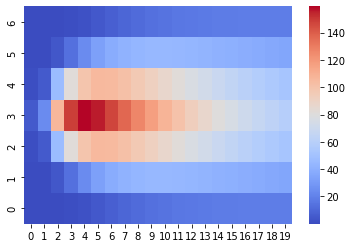

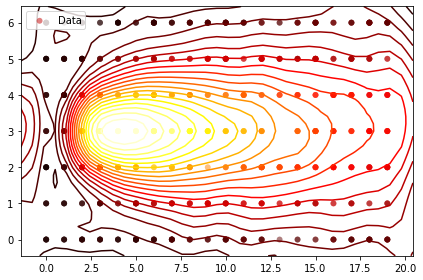

In [4]:
graph_dim = (20, 7)
graph_unity = 1

################## Parameters of the Gaussian dispersion model #####################
Q = 10000 # Pollution sources emission rate (g/s)
u = 2 # Wind speed (m/s)
h_s = 25 # Pollution sources height (m)
g = 9.8 #  Gravity constant (m/s²)
V = 6.03e-10 # Volumetric flow (m3/s)
T_a = 288.15 # Ambient air temperature 15°C -> K
T_s = 303.15 # Pollutant temperature 30°C -> K
a_y = 0.34
b_y = 0.82
a_z = 0.275
b_z = 0.69
####################################################################################

graph = construct_graph(graph_dim, graph_unity)
X_v = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
means = compute_means(graph_dim, 27, Q, u, h_s, g, V, T_a, T_s, a_y, b_y, a_z, b_z, display=True)
means[0], means[120] = 10.8339689395607643, 10.8339689395607643
means[1], means[121] = 11.526398647810964, 11.526398647810964
means[2], means[122] = 12.278479893954115, 12.278479893954115
means[3], means[123] = 12.648879083228234, 12.648879083228234
means[4], means[124] = 13.278479893954115, 13.278479893954115
#print(means)

nb_agents = 5
exploration_steps = 140
variance_lengthscale = [10, 2]
memory_window = 1000
gamma = 0.995

variances = [[0, 0, 0] for _ in range(graph.number_of_nodes())]
#covariances = [[0, 0, 0, 0] for _ in range(graph.number_of_nodes())]
liste_covariances = [[[0, 0, 0, 0] for _ in range(graph.number_of_nodes())] for _ in range(graph.number_of_nodes())]

incertitude, x, y = collect_pilot_data(nb_agents, exploration_steps, graph, graph_dim, means, variance_lengthscale[0], variance_lengthscale[1], memory_window, gamma)

x = np.reshape(x, (nb_agents*exploration_steps,2))
y = np.reshape(y, (nb_agents*exploration_steps,1))

gp_model = GPy.models.GPRegression(x, y, GPy.kern.RBF(2))
gp_model.optimize(messages=False)

moyenne, var, l = hyperparameters_estimator(gp_model, graph, graph_dim, memory_window, gamma)
print("Variance: ", var)
print("Lengthscale: ", l)
print("Carte: ", moyenne)

gp_model.plot()
#print(gp_model.predict(np.array([[0, 0]]))[0])
#print(gp_model.predict(np.array([[4, 4]]))[0])
print("Incertitude initiale : ", incertitude_initiale(sigma_matrix(gp_model, X_v), graph))

In [5]:
def update_gp_model(gp_model, x, y, display_gp_model=False):
    X = np.concatenate((gp_model.X, x))[-6000:]
    Y = np.concatenate((gp_model.Y, y))[-6000:]
    gp_model.set_XY(X, Y)
    #gp_model.optimize(messages=False)
    if display_gp_model:
        display(gp_model)
    return gp_model

def take_measurements(nodes, means, X_v, graph_dim, memory_window, gamma):
    simulation_kernel = GPy.kern.RBF(input_dim = 2, variance=variance_lengthscale[0], lengthscale=variance_lengthscale[1])
    cov = simulation_kernel.K(X_v)
    Y_v = np.random.multivariate_normal(np.array(means), cov, 1)[0]
    Y_v = np.reshape(Y_v, (len(Y_v),1))
    Y_v[Y_v<0] = 0.1
    
    for i in nodes:
        l = variances[i]
        l[0], l[1], l[2] = weighted_variance(l[0], l[1], l[2], Y_v[i][0], memory_window, gamma)
    
    sorted_nodes = sorted(nodes)
    
    for j in range(len(sorted_nodes)):
            if j==0 or sorted_nodes[j]!=sorted_nodes[j-1]:
                for i in range(len(sorted_nodes)):
                    if sorted_nodes[i]!=sorted_nodes[j] and (sorted_nodes[i]!=sorted_nodes[i-1] or i==0):
                        if distance(X_v[sorted_nodes[j]], X_v[sorted_nodes[i]])<=2.83:
                            l = liste_covariances[sorted_nodes[j]][sorted_nodes[i]]
                            l[0], l[1], l[2], l[3] = weighted_covariance(l[0], l[1], l[2], l[3], Y_v[sorted_nodes[j]], Y_v[sorted_nodes[i]], memory_window, gamma)
    """
    if sorted_nodes[0]==0:
        for i in range(1,len(sorted_nodes)):
            if sorted_nodes[i]!=sorted_nodes[i-1]:
                l = covariances[sorted_nodes[i]]
                l[0], l[1], l[2], l[3] = weighted_covariance(l[0], l[1], l[2], l[3], Y_v[0], Y_v[sorted_nodes[i]], memory_window, gamma)
    """
    return X_v[nodes], Y_v[nodes]

In [6]:
class pfeEnv(py_environment.PyEnvironment):

    def __init__(self, graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, variance_0, lengthscale_0, memory_window, gamma, train_env=True):
        self.nb_agents = nb_agents
        self.graph = graph
        self.graph_unity = graph_unity
        self.graph_dim = graph_dim
        self.initial_budgets = budgets/self.graph_unity
        self.budgets = self.initial_budgets.copy()
        if initial_positions!=None:
            self.initial_positions = copie_paths(initial_positions)
            self.paths = copie_paths(initial_positions)
        else:
            self.initial_positions = None
            self.paths = [[random.randint(0, self.graph.number_of_nodes()-1)] for i in range(self.nb_agents)]
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)]
        self.formater()
        self.X_v = np.array([self.graph.nodes[i]["coord"] for i in range(self.graph.number_of_nodes())])
        self.gp_model = gp_model
        self.X_s = [[] for i in range(self.nb_agents)]
        self.dones = [False for i in range(self.nb_agents)]
        self.cpt_done = 0
        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=3, name="action")
        self._observation_spec = array_spec.BoundedArraySpec(shape=(self.nb_agents*2,), dtype=np.float32, minimum=np.zeros((self.nb_agents*2,)), name="observation")
        self._state = flatten([self.graph.nodes[self.current_node(i)]["coord"] for i in range(self.nb_agents)])
        self._episode_ended = False
        #################################
        self.cpt_update_gp_model = 0
        self.memory_window, self.gamma = memory_window, gamma
        self.x, self.y = np.array([]), np.array([])
        self.liste_variances, self.liste_lengthscales = [variance_0], [lengthscale_0]
        self.train_env = train_env
        
    def current_node(self, id_agent):
        return self.paths[id_agent][-1]

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec
    
    def formater(self):
        for i in range(len(self.neighbors)):
            liste = self.neighbors[i]
            node = self.current_node(i)
            try:
                if liste[0]>=node-1:
                    liste.insert(0,-1)
                if liste[1]!=node-1:
                    liste.insert(1,-1)
                if liste[2]!=node+1:
                    liste.insert(2,-1)
            except:
                pass
            for _ in range(4-len(liste)):
                liste.append(-1)

    def _reset(self):
        if self.initial_positions!=None:
            self.paths = copie_paths(self.initial_positions)
        else:
            self.paths = [[random.randint(0, self.graph.number_of_nodes()-1)] for i in range(self.nb_agents)]
        self._state = flatten([self.graph.nodes[self.current_node(i)]["coord"] for i in range(self.nb_agents)])
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)] 
        self.formater()
        self.budgets = self.initial_budgets.copy()
        self.X_s = [[] for i in range(self.nb_agents)]
        self.dones = [False for i in range(self.nb_agents)]
        self.cpt_done = 0
        self._episode_ended = False
        return ts.restart(np.array(self._state, dtype=np.float32))
        
    def _step(self, abstract_actions):
        if self._episode_ended:
            return self.reset()
        actions = []
        for i in range(self.nb_agents):
            actions.append(self.neighbors[i][abstract_actions[i]])
        X_s_old = preprocessing(self.X_s)
        for i in range(self.nb_agents):
            if not self.dones[i]:
                if actions[i]!=-1:
                    self.X_s[i].append([graph.nodes[actions[i]]["coord"][0], graph.nodes[actions[i]]["coord"][1]])
                    self.budgets[i] -= 1
                else:
                    actions[i] = self.current_node(i)
                    self.budgets[i] -= 0.3
                if self.budgets[i]<1:
                    self.dones[i] = True
                    self.cpt_done += 1
                self.paths[i].append(actions[i])
                coord = self.graph.nodes[self.current_node(i)]["coord"]
                self._state[2*i] = coord[0]
                self._state[2*i+1] = coord[1]
        
        
        positions, mesures = take_measurements(actions, means, self.X_v, self.graph_dim, self.memory_window, self.gamma)
        if self.train_env:
            m, var, l = hyperparameters_estimator(self.gp_model, self.graph, self.graph_dim, self.memory_window, self.gamma)
            self.liste_variances.append(var)
            self.liste_lengthscales.append(l)
            self.moy = m
            self.x = concatenate(self.x, positions)
            self.y = concatenate(self.y, mesures)
            self.cpt_update_gp_model = (self.cpt_update_gp_model + 1)%560
            if self.cpt_update_gp_model==0:
                self.gp_model = update_gp_model(self.gp_model, self.x, self.y)
                self.x, self.y = np.array([]), np.array([])
        
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)]
        self.formater()
        reward = reward_function(self.gp_model, self.X_v, X_s_old, preprocessing(self.X_s))
        if self.cpt_done==self.nb_agents:
            self._episode_ended = True
            return ts.termination(np.array(self._state, dtype=np.float32), reward)
        return ts.transition(np.array(self._state, dtype=np.float32), reward=reward, discount=0.97)

In [7]:
num_iterations = 20000
fc_layer_params = (128,64,128,)
replay_buffer_capacity = 10000
batch_size = 128
learning_rate = 1e-5

num_atoms = 51
min_q_value = -20
max_q_value = 20
n_step_update = 3

num_eval_episodes = 10
log_eval_interval = 1000

max_episode_length = 140
budgets = 140 * np.ones(nb_agents)

In [8]:
initial_positions = None #[[random.randint(0, graph.number_of_nodes()-1)] for i in range(nb_agents)]
train_py_env = wrappers.TimeLimit(pfeEnv(graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, var, l, memory_window, gamma, train_env=True), duration=max_episode_length)
eval_py_env = wrappers.TimeLimit(pfeEnv(graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, var, l, memory_window, gamma, train_env=False), duration=max_episode_length)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

agents_tf = []
eval_policies = []
collect_policies = []
policies_checkpointers = []

for i in range(nb_agents):
    categorical_q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=num_atoms,
        fc_layer_params=fc_layer_params)
        
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    train_step_counter = tf.compat.v2.Variable(0)

    agents_tf.append(categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        categorical_q_network=categorical_q_net,
        optimizer=optimizer,
        min_q_value=min_q_value,
        max_q_value=max_q_value,
        n_step_update=n_step_update,
        target_update_period=5,
        target_update_tau=0.05,
        td_errors_loss_fn=common.element_wise_squared_loss,
        gamma=0.99,
        train_step_counter=train_step_counter))

    agents_tf[-1].initialize()

    eval_policies.append(agents_tf[-1].policy)
    collect_policies.append(agents_tf[-1].collect_policy)
    collect_policies[-1]._epsilon = 1.
    
    policies_checkpointers.append(common.Checkpointer(ckpt_dir='Collisions_Politique__'+str(i), policy=eval_policies[-1]))

In [9]:
def compute_avg_return(environment, policies, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        while not time_step.is_last():
            actions = []
            for i in range(nb_agents):
                actions.append(policies[i].action(time_step).action.numpy()[0])
            actions = tf.convert_to_tensor([actions])
            time_step = environment.step(actions)
            episode_return += time_step.reward
        total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def random_compute_avg_return(environment, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        while not time_step.is_last():
            actions = [random.randint(0, 3) for _ in range(nb_agents)]
            actions = tf.convert_to_tensor([actions])
            time_step = environment.step(actions)
            episode_return += time_step.reward
        total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def collect_step(environment, environment_py, policies):
    time_step = environment.current_time_step()
    actions = []
    actions_step = []
    dones = environment_py.dones.copy()
    for i in range(nb_agents):
        actions_step.append(policies[i].action(time_step))
        actions.append(actions_step[-1].action.numpy()[0])
    actions = tf.convert_to_tensor([actions])
    next_time_step = environment.step(actions)
    rewards = credit_assignment(environment_py, next_time_step.reward.numpy()[0], dones)
    for i in range(nb_agents):
        if not dones[i]:
            nts = next_time_step._replace(reward=tf.convert_to_tensor([rewards[i]], dtype=np.float32))
            traj = trajectory.from_transition(time_step, actions_step[i], nts)
            replay_buffers[i].add_batch(traj)
            
def random_collect_step(environment, environment_py):
    time_step = environment.current_time_step()
    actions = [random.randint(0, 3) for _ in range(nb_agents)]
    actions = tf.convert_to_tensor([actions])
    next_time_step = environment.step(actions)

In [11]:
replay_buffers = []
for i in range(nb_agents):
    replay_buffers.append(tf_agents.replay_buffers.TFUniformReplayBuffer(
        data_spec = agents_tf[i].collect_data_spec,
        batch_size = train_env.batch_size,
        max_length = replay_buffer_capacity))

iterators = []
for i in range(nb_agents):
    dataset = replay_buffers[i].as_dataset(
        num_parallel_calls=3,
        sample_batch_size=batch_size,
        num_steps=2).prefetch(3)
    iterators.append(iter(dataset))

In [12]:
print(compute_avg_return(eval_env, collect_policies, num_eval_episodes))
print(compute_avg_return(eval_env, eval_policies, num_eval_episodes))

steps = []
avg = []
err = []

for i in range(nb_agents):
    agents_tf[i].train = common.function(agents_tf[i].train)
    agents_tf[i].train_step_counter.assign(0)

for _ in tqdm(range(500)):
    collect_step(train_env, train_py_env, collect_policies)

for step in tqdm(range(1, num_iterations+1)):
    if step%100==0:
        for cp in collect_policies:
            cp._epsilon = max(cp._epsilon*0.99, 0.1)
        
    if step==2000:
        variance_lengthscale[0] -= 1
    if step==10000:
        variance_lengthscale[1] -= 1
    #if step==40000:
        #means = [80, 50, 40, 35, 30, 50, 47.5, 45, 37.5, 31.25, 40, 45, 42.5, 40, 32.5, 35, 37.5, 40, 37.5, 35, 30, 31.25, 32.5, 35, 32.5]
    
    for _ in range(1):
        collect_step(train_env, train_py_env, collect_policies)
    
    for i in range(nb_agents):
        experience, _ = next(iterators[i])
        agents_tf[i].train(experience=experience)
        
    if step%log_eval_interval==0:
        avg_return = compute_avg_return(eval_env, eval_policies, num_eval_episodes)
        steps.append(step)
        avg.append(avg_return)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        print("Variance : ", train_py_env.liste_variances[-1])
        print("Lengthscale : ", train_py_env.liste_lengthscales[-1])
        err.append(np.mean((train_py_env.moy-means)**2))
        print("MSE de la moyenne : ", err[-1])
        print("Epsilons : ", [cp._epsilon for cp in collect_policies])

226.2114


KeyboardInterrupt: 

In [ ]:
print(steps)
print(avg)
print(err)
print(train_py_env.liste_variances)
print(train_py_env.liste_lengthscales)

In [14]:
episodes = 3

envs = []
for _ in range(episodes):
    initial_positions = [[random.randint(0, graph.number_of_nodes()-1)] for i in range(nb_agents)]
    eval_py_env = wrappers.TimeLimit(pfeEnv(graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, var, l, memory_window, 0.99, train_env=False), duration=max_episode_length)
    eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)
    envs.append((eval_env,eval_py_env))

In [16]:
variances = [[0, 0, 0] for _ in range(graph.number_of_nodes())]
liste_covariances = [[[0, 0, 0, 0] for _ in range(graph.number_of_nodes())] for _ in range(graph.number_of_nodes())]

ms, vvs, ccs = [], [], []
rewards = []
for ll in tqdm(range(episodes)):
    eval_env, eval_py_env = envs[ll][0], envs[ll][1]
    time_step = eval_env.reset()
    episode_return = 0.0
    while not time_step.is_last():
        actions = [random.randint(0, 3) for _ in range(nb_agents)]
        #actions = []
        #for i in range(nb_agents):
            #actions.append(eval_policies[i].action(time_step).action.numpy()[0])
        actions = tf.convert_to_tensor([actions])
        time_step = eval_env.step(actions)
        episode_return += time_step.reward
    #print(eval_py_env.paths)
    #print(episode_return.numpy()[0])
    m, vv, cc = hyperparameters_estimator(eval_py_env.gp_model, eval_py_env.graph, eval_py_env.graph_dim, eval_py_env.memory_window, eval_py_env.gamma)
    ms.append(m)
    vvs.append(vv)
    ccs.append(cc)
    #print("##################################")
    rewards.append(episode_return.numpy()[0])
    
print("Moyenne : ", np.mean(np.array(rewards)))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:46<00:00, 15.44s/it]

Moyenne :  295.36746


In [ ]:
# RL
# Agents : 5, Var : 10, Lengthscale : 2, Layers : (128,64), Episode : 150, Training Steps : 25000, Batch size : 128
# gamma : 0.99, memory_window : 1000
print(ms)
print("################")
print(vvs)
print("################")
print(ccs)
print("################")
print(rewards)

In [ ]:
# Random
# Agents : 5, Var : 10, Lengthscale : 2, Layers : (128,64), Episode : 150, Training Steps : 25000, Batch size : 128
# gamma : 0.99, memory_window : 1000
print(ms)
print("################")
print(vvs)
print("################")
print(ccs)
print("################")
print(rewards)

In [ ]:
# RL
# Agents : 5, Var : 10, Lengthscale : 2, Layers : (128,64), Episode : 150, Training Steps : 25000, Batch size : 128
# gamma : 0.993, memory_window : 1000
print(ms)
print("################")
print(vvs)
print("################")
print(ccs)
print("################")
print(rewards)

In [ ]:
# Random
# Agents : 5, Var : 10, Lengthscale : 2, Layers : (128,64), Episode : 150, Training Steps : 25000, Batch size : 128
# gamma : 0.993, memory_window : 1000
print(ms)
print("################")
print(vvs)
print("################")
print(ccs)
print("################")
print(rewards)

In [ ]:
# RL
# Agents : 5, Var : 10, Lengthscale : 2, Layers : (128,64), Episode : 150, Training Steps : 25000, Batch size : 128
# gamma : 0.996, memory_window : 1000
print(ms)
print("################")
print(vvs)
print("################")
print(ccs)
print("################")
print(rewards)

In [ ]:
# Random
# Agents : 5, Var : 10, Lengthscale : 2, Layers : (128,64), Episode : 150, Training Steps : 25000, Batch size : 128
# gamma : 0.996, memory_window : 1000
print(ms)
print("################")
print(vvs)
print("################")
print(ccs)
print("################")
print(rewards)

In [ ]:
# RL
# Agents : 5, Var : 10, Lengthscale : 2, Layers : (128,64), Episode : 150, Training Steps : 25000, Batch size : 128
# gamma : 0.999, memory_window : 1000
print(ms)
print("################")
print(vvs)
print("################")
print(ccs)
print("################")
print(rewards)

In [ ]:
# Random
# Agents : 5, Var : 10, Lengthscale : 2, Layers : (128,64), Episode : 150, Training Steps : 25000, Batch size : 128
# gamma : 0.999, memory_window : 1000
print(ms)
print("################")
print(vvs)
print("################")
print(ccs)
print("################")
print(rewards)

## RL vs Random

In [17]:
for i in range(nb_agents):
    policies_checkpointers[i].save(global_step=agents_tf[i].train_step_counter)